In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data
from sklearn.model_selection import train_test_split

# Display Dataset

In [2]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset
Mglass1 = MackeyGlassDataset(10000, 5, tau=17, seed=0)
Mglass2 = MackeyGlassDataset(10000, 2, tau=20, seed=0)

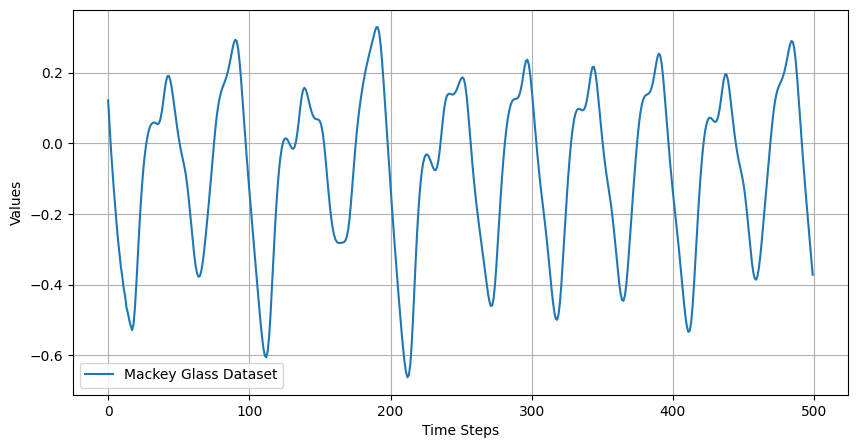

In [3]:
dataset = torch.utils.data.DataLoader(Mglass1, batch_size=1, shuffle=False)
dataset = np.array([data[0] for data in dataset]).reshape(-1, 1)
# loop through the input data (data[0]) and convert it to numpy array with shape of colomn vector

plt.figure(figsize=(10, 5))
plt.plot(dataset[:500], label='Mackey Glass Dataset')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('CPU is available')


GPU is available


# ESN 

In [5]:
from Models.Reservoir import Reservoir
from Models.Echostate import ESN

In [6]:
time = torch.linspace(0, 10, 1000)
inputs, targets = Mglass2[0]


# Normalize data to [-1, 1]
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min()) * 2 - 1
targets = (targets - targets.min()) / (targets.max() - targets.min()) * 2 - 1

print (inputs.shape, targets.shape)

# Split into train and test
train_data, test_data = inputs[:800], inputs[800:]

# Initialize ESN
Res = Reservoir(input_dim=1, reservoir_dim=300, output_dim=1, 
                spectral_radius=0.90, leak_rate=0.3)

ESN = ESN(input_dim=1, reservoir_dim=300, output_dim=1, 
            spectral_radius=0.90, leak_rate=0.3)

torch.Size([9999, 1]) torch.Size([9999, 1])


In [7]:
eigenvalues, _ = torch.linalg.eig(Res.W)  
λ_max = torch.max(torch.abs(eigenvalues))  
print(f"Actual λ_max after scaling: {λ_max.item()} (should match spectral radius {Res.spectral_radius})")

Actual λ_max after scaling: 0.9000011682510376 (should match spectral radius 0.9)


In [8]:
Res.train_readout(inputs,targets)
ESN.train_readout(inputs,targets)

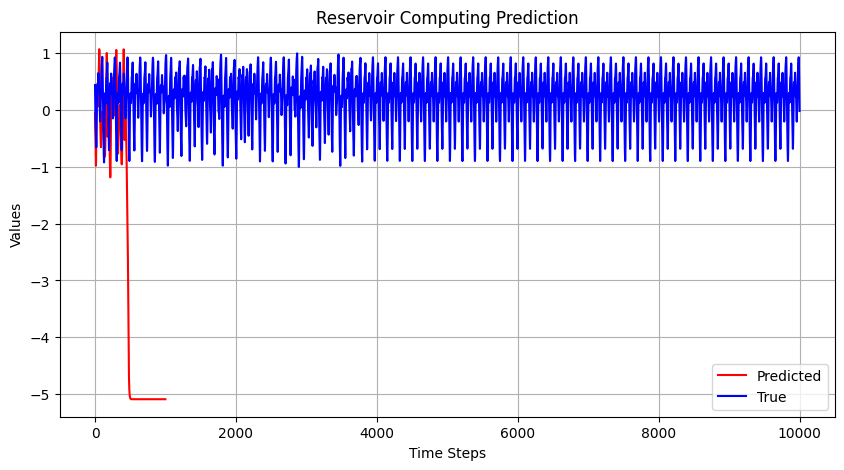

In [9]:
predictions = Res.predict(train_data[-1:], steps=1000)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predicted', color='red')
plt.plot(targets, label='True', color='blue')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.title('Reservoir Computing Prediction')
plt.show()


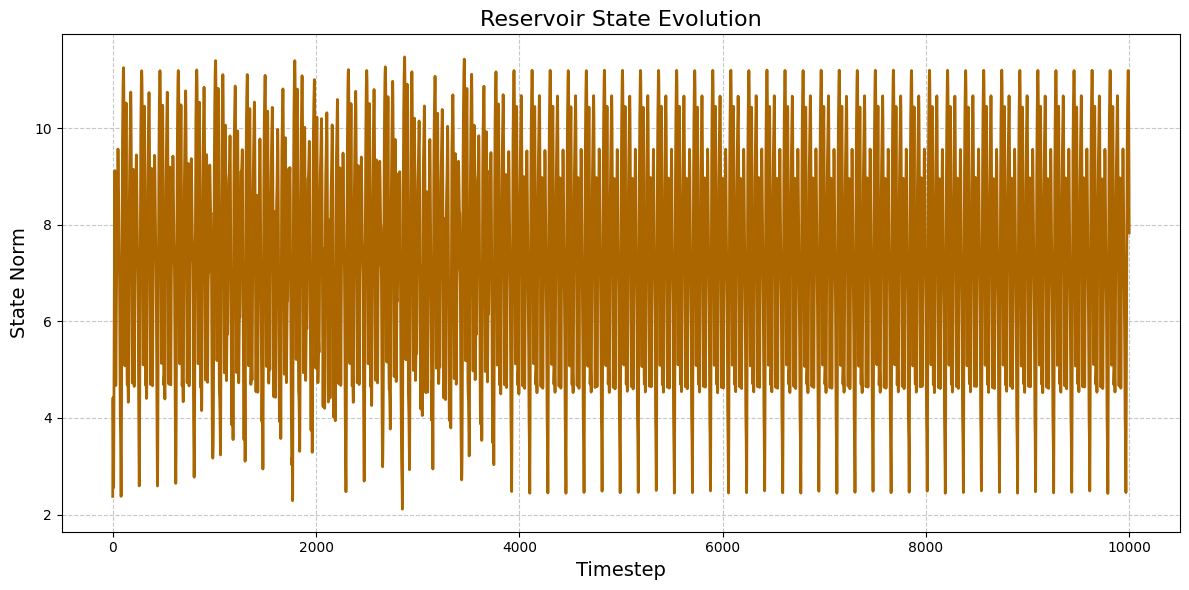

In [10]:
plt.figure(figsize=(12, 6))
plt.plot([state.norm().item() for state in Res.reservoir_states], color='#AC6600', linewidth=2)
plt.xlabel("Timestep", fontsize=14)
plt.ylabel("State Norm", fontsize=14)
plt.title("Reservoir State Evolution", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

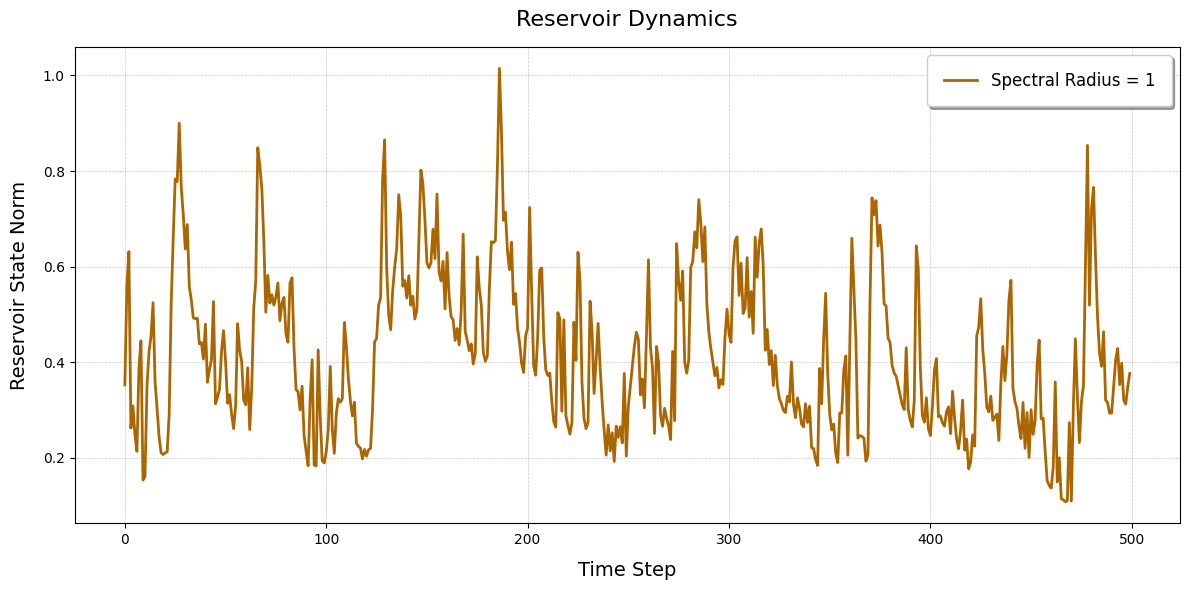

Approximate Lyapunov Exponent: -3.0907
Stable / Periodic Dynamics


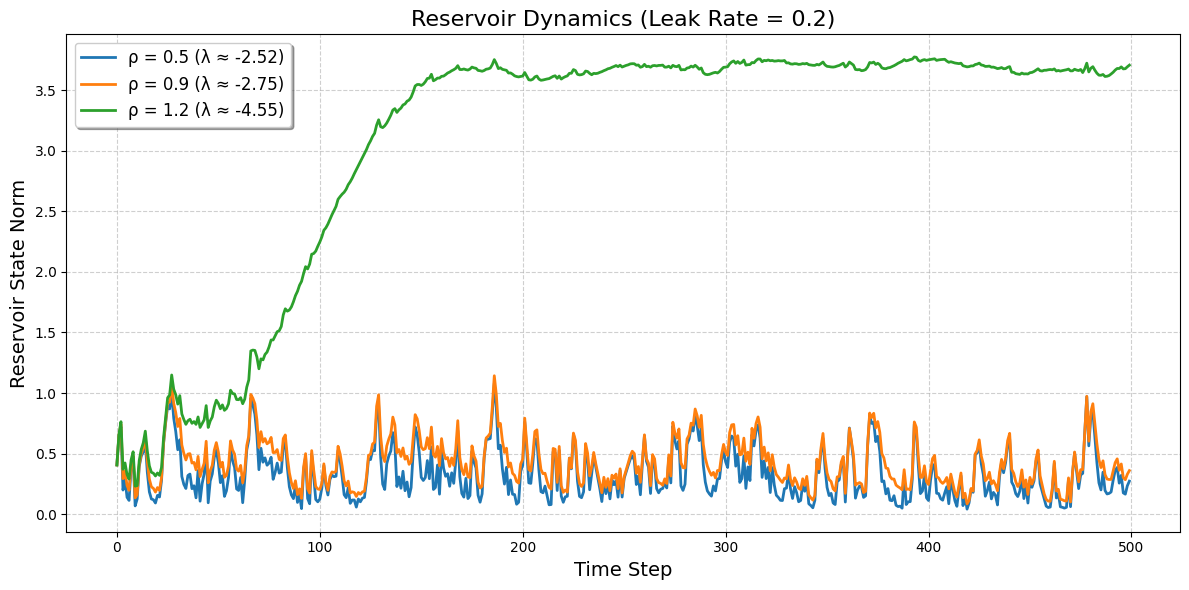

In [11]:
from HelperScripts.Testers import Test_lyapunov,Test_Spectral_radii
Test_lyapunov(spectral_radius=1)
Test_Spectral_radii()

Imports Done!

Using device: cuda



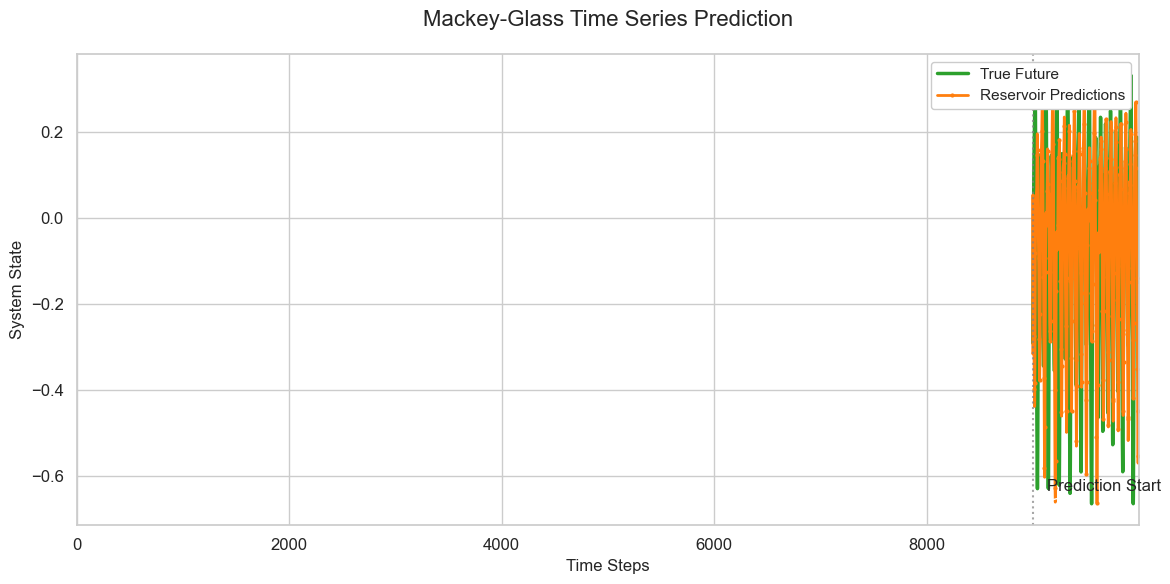

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Ensure the correct path to MackeyGlass module
#sys.path.append(os.path.abspath(os.path.join(__file__, '..', '..')))
from Datasets.MackeyGlassDataset import MackeyGlassDataset
from Models.Reservoir import Reservoir
from Models.Echostate import ESN

print("Imports Done!\n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

Mglass1 = MackeyGlassDataset(10000, 5, tau=17, seed=0)
inputs, targets = Mglass1[0]
inputs = inputs.to(device)
targets = targets.to(device)

# Create reservoir
reservoir = Reservoir(input_dim=1, reservoir_dim=500, output_dim=1, 
                     spectral_radius=1.1, leak_rate=0.3, sparsity=0.9)
reservoir = reservoir.to(device)

# Train the readout layer
reservoir.train_readout(inputs, targets, alpha=1e-6)

# Predictions
steps = 1000
with torch.no_grad():
    initial_input = inputs[-1:] 
    predictions = reservoir.predict(initial_input, steps=steps, teacher_forcing=None, warmup=3)
predictions = predictions.squeeze(1).cpu().numpy()

inputs_plot = inputs[:-steps].squeeze(1).cpu().numpy()  # (800,)
true_future = targets[-steps:].squeeze(1).cpu().numpy()  # (200,)

######-------------------Plots-------------------######
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6), dpi=100)

# Training data
plt.plot(range(len(inputs_plot)), inputs_plot, 
         color='#1f77b4', linewidth=2.5, 
         label="Training Data")

# True future data
plt.plot(range(len(inputs_plot), len(inputs_plot) + steps), 
         true_future, 
         color='#2ca02c', linewidth=2.5,
         label="True Future")

# Reservoir Predictions
plt.plot(range(len(inputs_plot), len(inputs_plot) + steps), 
         predictions, 
         color='#ff7f0e', linewidth=2,
         marker='o', markersize=2, markevery=5,
         label="Reservoir Predictions")

# Vertical line
plt.axvline(x=len(inputs_plot), color='gray', linestyle=':', alpha=0.7)

# Annotations
plt.annotate('Prediction Start', 
             xy=(len(inputs_plot), np.min(inputs_plot)), 
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Formatting
plt.title("Mackey-Glass Time Series Prediction", fontsize=16, pad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, len(inputs_plot) + steps)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("System State", fontsize=12)
plt.legend(loc='upper right', framealpha=1)

# Adjust layout
plt.tight_layout()
plt.show()